In [1]:
import pandas as pd

df = pd.read_csv('ecommerce_returns_synthetic_data.csv')
print(df.head())
print('\nDataset Info:')
print(df.info())

      Order_ID    Product_ID       User_ID  Order_Date Return_Date  \
0  ORD00000000  PROD00000000  USER00000000  05-08-2023  26-08-2024   
1  ORD00000001  PROD00000001  USER00000001  09-10-2023  09-11-2023   
2  ORD00000002  PROD00000002  USER00000002  06-05-2023         NaN   
3  ORD00000003  PROD00000003  USER00000003  29-08-2024         NaN   
4  ORD00000004  PROD00000004  USER00000004  16-01-2023         NaN   

  Product_Category  Product_Price  Order_Quantity Return_Reason Return_Status  \
0         Clothing         411.59               3  Changed mind      Returned   
1            Books         288.88               3    Wrong item      Returned   
2             Toys         390.03               5           NaN  Not Returned   
3             Toys         401.09               3           NaN  Not Returned   
4            Books         110.09               4           NaN  Not Returned   

   User_Age User_Gender User_Location Payment_Method Shipping_Method  \
0        58        M

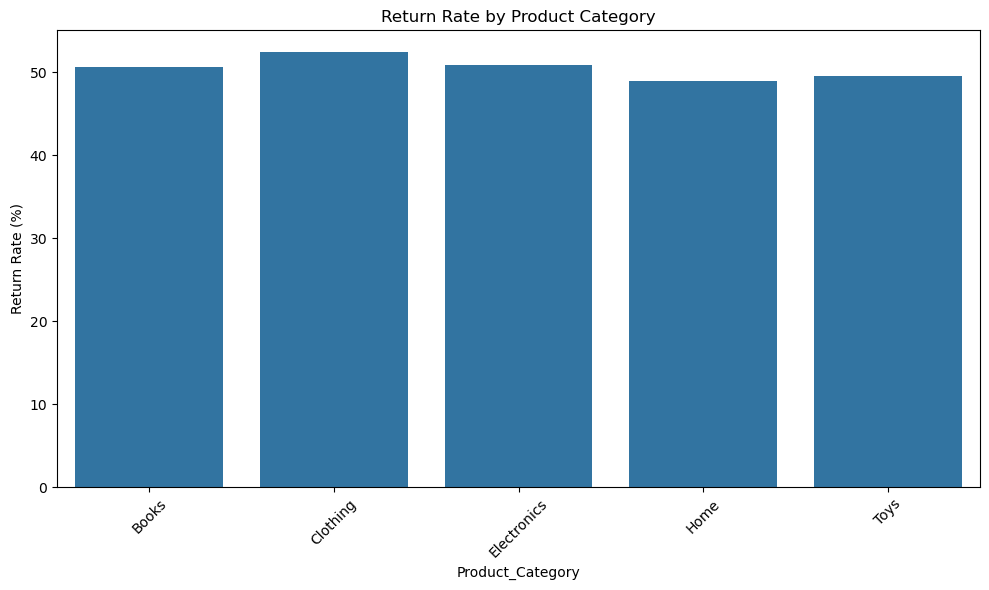

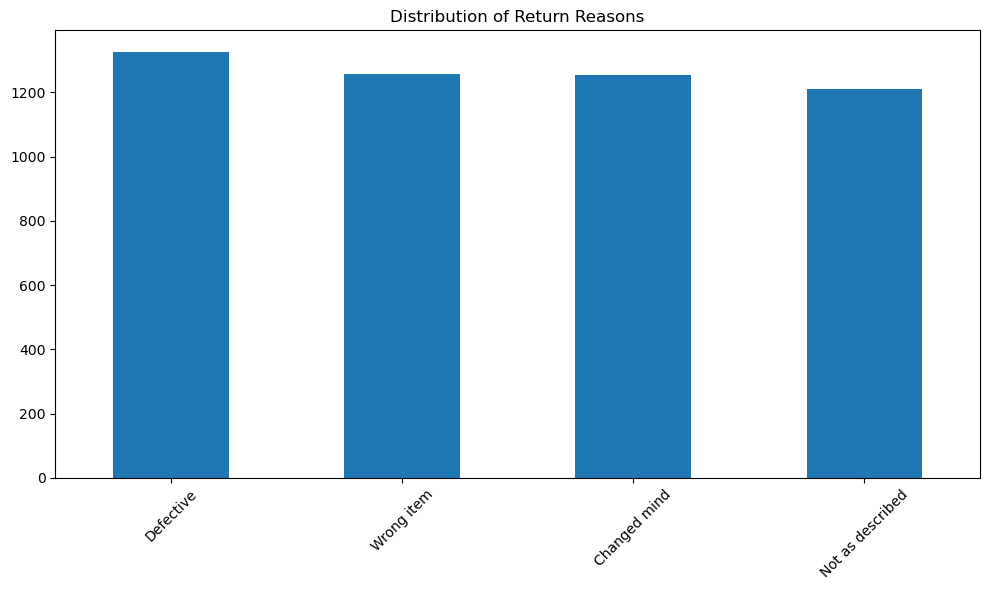


Return Rates by Category:
                  Total_Orders  Returns  Return_Rate
Product_Category                                    
Clothing                  2000     1049        52.45
Electronics               1985     1011        50.93
Books                     2041     1034        50.66
Toys                      1944      963        49.54
Home                      2030      995        49.01


In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt


df = pd.read_csv('ecommerce_returns_synthetic_data.csv')


df['Order_Date'] = pd.to_datetime(df['Order_Date'], format='%d-%m-%Y')
df['Return_Date'] = pd.to_datetime(df['Return_Date'], format='%d-%m-%Y', errors='coerce')

return_by_category = df.groupby('Product_Category').agg({
    'Order_ID': 'count',
    'Return_Status': lambda x: (x == 'Returned').sum()
}).rename(columns={'Order_ID': 'Total_Orders', 'Return_Status': 'Returns'})

return_by_category['Return_Rate'] = (return_by_category['Returns'] / return_by_category['Total_Orders'] * 100).round(2)


plt.figure(figsize=(10, 6))
sns.barplot(data=return_by_category.reset_index(), 
            x='Product_Category', 
            y='Return_Rate')
plt.xticks(rotation=45)
plt.title('Return Rate by Product Category')
plt.ylabel('Return Rate (%)')
plt.tight_layout()
plt.show()


return_reasons = df[df['Return_Status'] == 'Returned']['Return_Reason'].value_counts()
plt.figure(figsize=(10, 6))
return_reasons.plot(kind='bar')
plt.title('Distribution of Return Reasons')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\nReturn Rates by Category:")
print(return_by_category.sort_values('Return_Rate', ascending=False))

C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


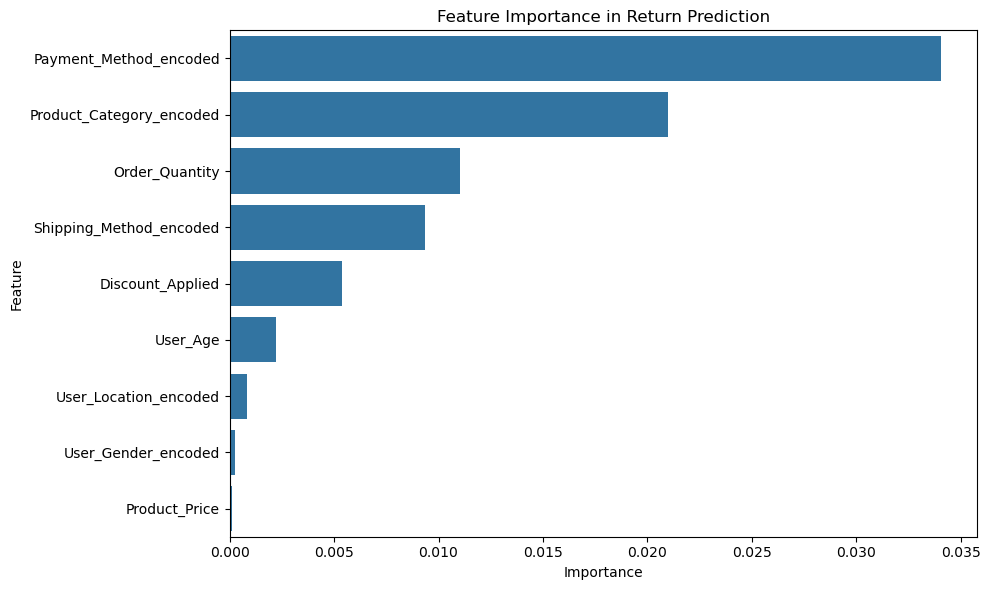


Top 10 High-Risk Products:
        Product_ID Product_Category  Product_Price  return_risk_score
6292  PROD00006292            Books         109.11          58.573855
6770  PROD00006770         Clothing           7.77          58.501666
5721  PROD00005721            Books          94.02          58.475401
9195  PROD00009195            Books         353.70          58.357008
1758  PROD00001758            Books          38.18          58.216646
6715  PROD00006715         Clothing         198.85          58.081799
2500  PROD00002500            Books         220.67          58.057846
3763  PROD00003763            Books         137.93          58.034297
2204  PROD00002204            Books         156.04          58.026542
6300  PROD00006300            Books         128.22          57.984378

Model Performance:
              precision    recall  f1-score   support

           0       0.48      0.36      0.41      1009
           1       0.48      0.60      0.53       991

    accuracy      

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import numpy as np


df['is_returned'] = (df['Return_Status'] == 'Returned').astype(int)


le_dict = {}
categorical_cols = ['Product_Category', 'User_Gender', 'User_Location', 
                   'Payment_Method', 'Shipping_Method']

for col in categorical_cols:
    le_dict[col] = LabelEncoder()
    df[col + '_encoded'] = le_dict[col].fit_transform(df[col])


X = df[[
    'Product_Price', 'Order_Quantity', 'User_Age', 'Discount_Applied',
    'Product_Category_encoded', 'User_Gender_encoded', 'User_Location_encoded',
    'Payment_Method_encoded', 'Shipping_Method_encoded'
]]
y = df['is_returned']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)


feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': abs(model.coef_[0])
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

df['return_risk_score'] = model.predict_proba(X)[:, 1] * 100


high_risk_products = df[['Product_ID', 'Product_Category', 'Product_Price', 'return_risk_score']]
high_risk_products = high_risk_products.sort_values('return_risk_score', ascending=False)
high_risk_products.to_csv('high_risk_products.csv', index=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='Importance', y='Feature')
plt.title('Feature Importance in Return Prediction')
plt.tight_layout()
plt.show()

print("\nTop 10 High-Risk Products:")
print(high_risk_products.head(10))

print("\nModel Performance:")
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

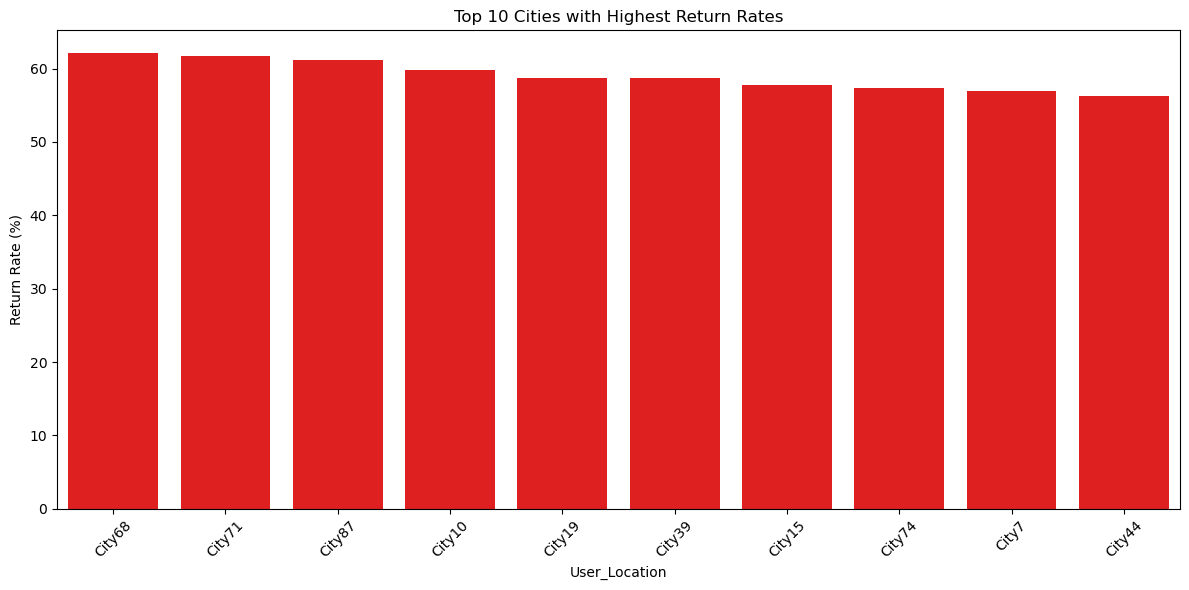

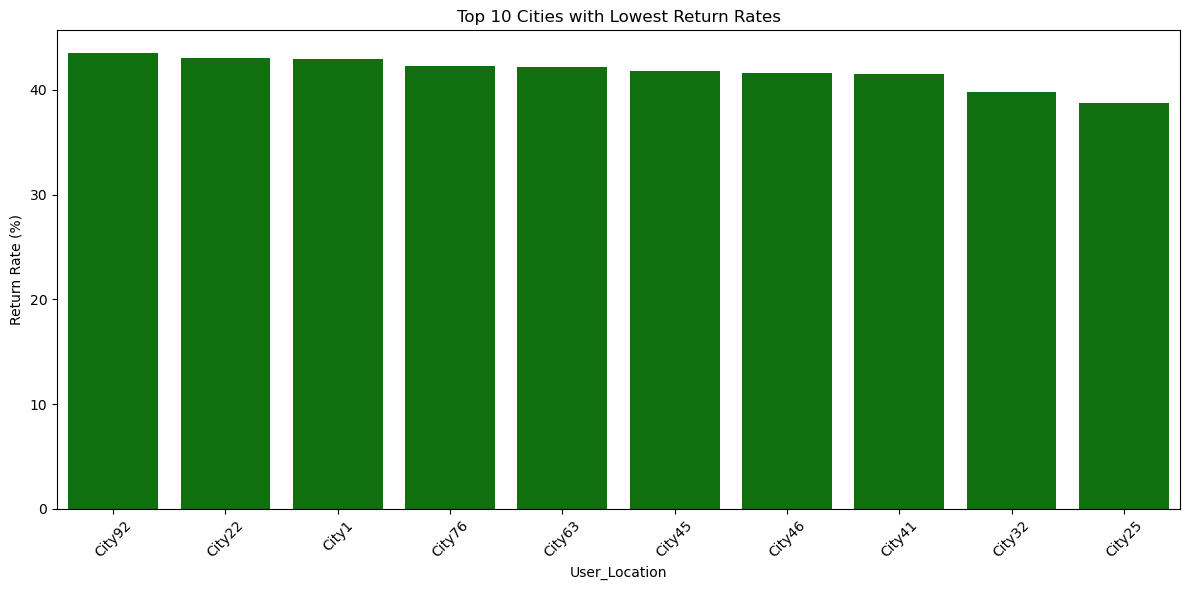


Geographical Return Rate Summary:

Overall Statistics:
count    100.00
mean      50.53
std        4.94
min       38.78
25%       47.59
50%       50.49
75%       54.00
max       62.11
Name: Return_Rate, dtype: float64

Correlation between Order Volume and Return Rate: -0.024


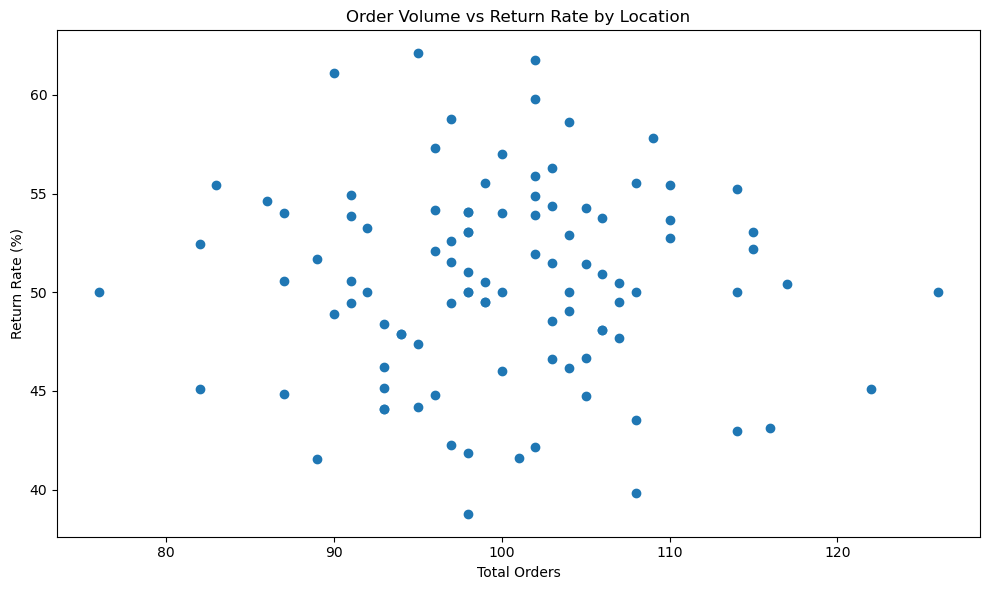


Top 10 Cities by Order Volume:
               Total_Orders  Returns  Return_Rate
User_Location                                    
City81                  126       63        50.00
City36                  122       55        45.08
City3                   117       59        50.43
City22                  116       50        43.10
City28                  115       60        52.17
City26                  115       61        53.04
City1                   114       49        42.98
City86                  114       57        50.00
City43                  114       63        55.26
City78                  110       59        53.64


In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


location_analysis = df.groupby('User_Location').agg({
    'Order_ID': 'count',
    'Return_Status': lambda x: (x == 'Returned').sum()
}).rename(columns={'Order_ID': 'Total_Orders', 'Return_Status': 'Returns'})

location_analysis['Return_Rate'] = (location_analysis['Returns'] / location_analysis['Total_Orders'] * 100).round(2)


location_analysis_sorted = location_analysis.sort_values('Return_Rate', ascending=False)


top_10_cities = location_analysis_sorted.head(10)
bottom_10_cities = location_analysis_sorted.tail(10)


plt.figure(figsize=(12, 6))
sns.barplot(data=top_10_cities.reset_index(), 
            x='User_Location', 
            y='Return_Rate',
            color='red')
plt.title('Top 10 Cities with Highest Return Rates')
plt.xticks(rotation=45)
plt.ylabel('Return Rate (%)')
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 6))
sns.barplot(data=bottom_10_cities.reset_index(), 
            x='User_Location', 
            y='Return_Rate',
            color='green')
plt.title('Top 10 Cities with Lowest Return Rates')
plt.xticks(rotation=45)
plt.ylabel('Return Rate (%)')
plt.tight_layout()
plt.show()

print("\nGeographical Return Rate Summary:")
print("\nOverall Statistics:")
print(location_analysis['Return_Rate'].describe().round(2))


correlation = location_analysis[['Total_Orders', 'Return_Rate']].corr().iloc[0,1]
print("\nCorrelation between Order Volume and Return Rate:", round(correlation, 3))

plt.figure(figsize=(10, 6))
plt.scatter(location_analysis['Total_Orders'], location_analysis['Return_Rate'])
plt.xlabel('Total Orders')
plt.ylabel('Return Rate (%)')
plt.title('Order Volume vs Return Rate by Location')
plt.tight_layout()
plt.show()


print("\nTop 10 Cities by Order Volume:")
top_volume_cities = location_analysis.sort_values('Total_Orders', ascending=False).head(10)
print(top_volume_cities)

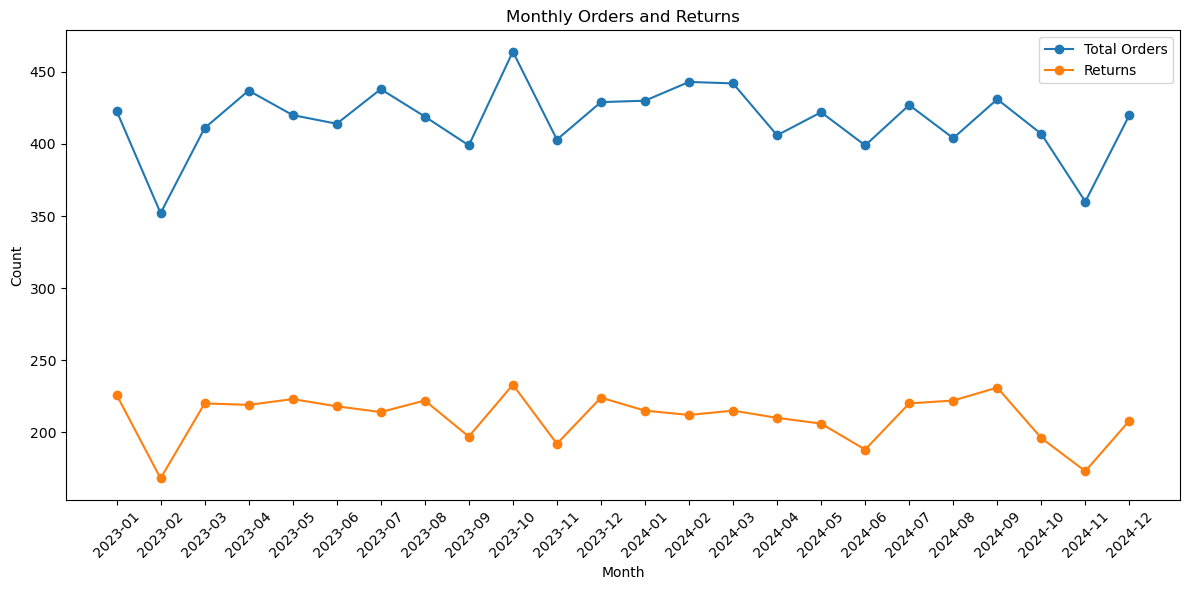

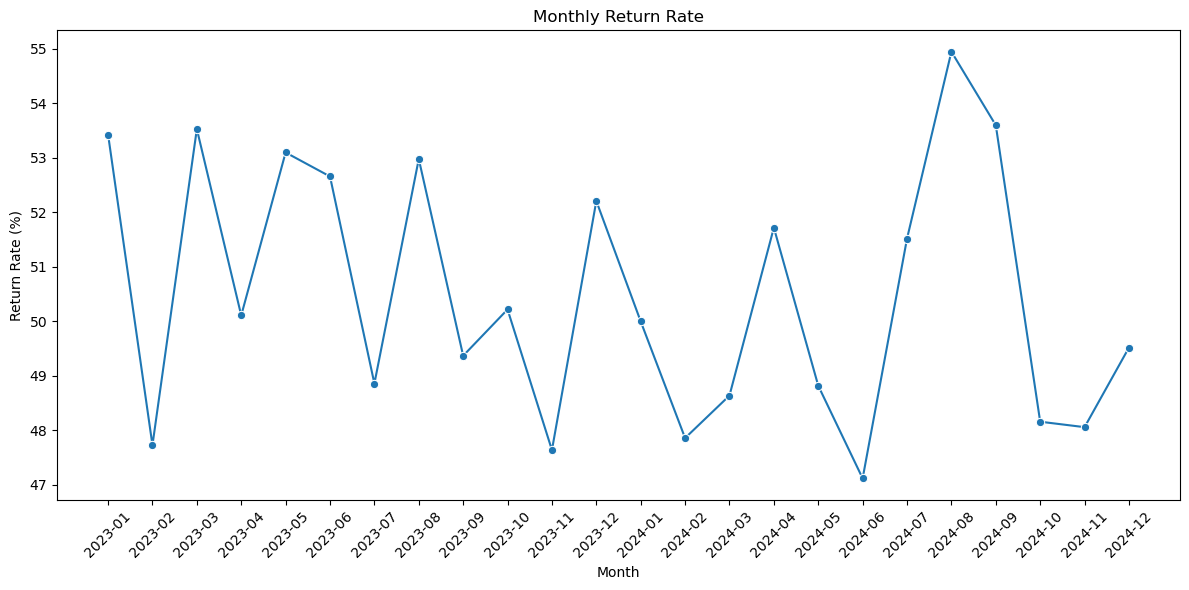

Monthly Order and Return Summary:
   Order_Month  Total_Orders  Returns  Return_Rate
0      2023-01           423      226        53.43
1      2023-02           352      168        47.73
2      2023-03           411      220        53.53
3      2023-04           437      219        50.11
4      2023-05           420      223        53.10
5      2023-06           414      218        52.66
6      2023-07           438      214        48.86
7      2023-08           419      222        52.98
8      2023-09           399      197        49.37
9      2023-10           464      233        50.22
10     2023-11           403      192        47.64
11     2023-12           429      224        52.21
12     2024-01           430      215        50.00
13     2024-02           443      212        47.86
14     2024-03           442      215        48.64
15     2024-04           406      210        51.72
16     2024-05           422      206        48.82
17     2024-06           399      188        47.

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


df['Order_Month'] = df['Order_Date'].dt.to_period('M').astype(str)


monthly_stats = df.groupby('Order_Month').agg({
    'Order_ID': 'count',
    'Return_Status': lambda x: (x == 'Returned').sum()
}).rename(columns={'Order_ID': 'Total_Orders', 'Return_Status': 'Returns'})
monthly_stats['Return_Rate'] = (monthly_stats['Returns'] / monthly_stats['Total_Orders'] * 100).round(2)


plt.figure(figsize=(12,6))
plt.plot(monthly_stats.index, monthly_stats['Total_Orders'], marker='o', label='Total Orders')
plt.plot(monthly_stats.index, monthly_stats['Returns'], marker='o', label='Returns')
plt.xticks(rotation=45)
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Monthly Orders and Returns')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,6))
sns.lineplot(data=monthly_stats, x=monthly_stats.index, y='Return_Rate', marker='o')
plt.xticks(rotation=45)
plt.xlabel('Month')
plt.ylabel('Return Rate (%)')
plt.title('Monthly Return Rate')
plt.tight_layout()
plt.show()


print("Monthly Order and Return Summary:")
print(monthly_stats.reset_index())


Top Product Categories with Highest Return Rates:
                  Total_Orders  Returns  Return_Rate (%)
Product_Category                                        
Clothing                  2000     1049            52.45
Electronics               1985     1011            50.93
Books                     2041     1034            50.66
Toys                      1944      963            49.54
Home                      2030      995            49.01


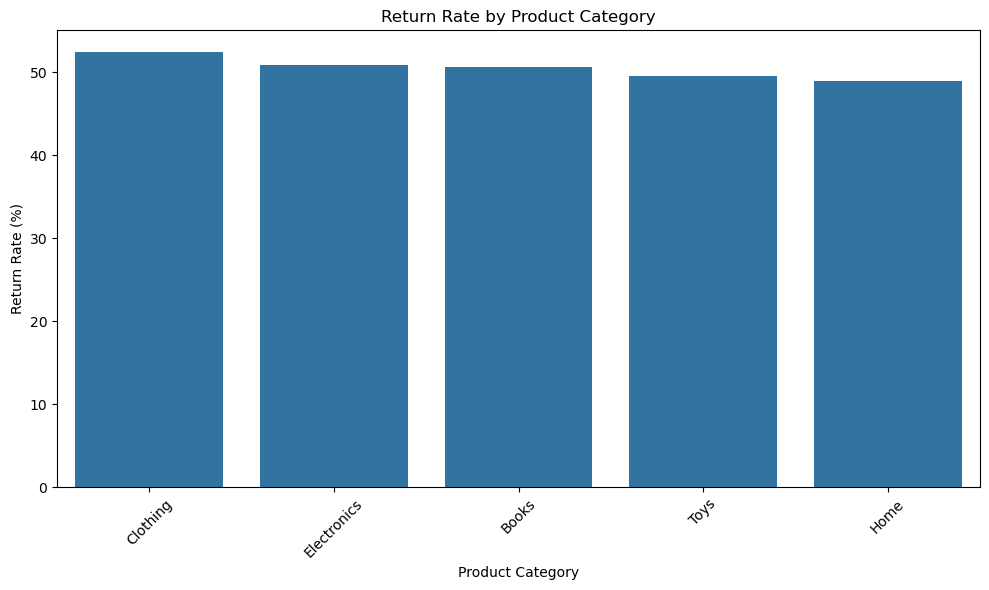

In [7]:
import pandas as pd
orders_by_category = df.groupby('Product_Category').size()
returns_by_category = df[df['Return_Status'] == 'Returned'].groupby('Product_Category').size()

return_rate = (returns_by_category / orders_by_category * 100).round(2)
return_rate_df = pd.DataFrame({'Total_Orders': orders_by_category, 'Returns': returns_by_category, 'Return_Rate (%)': return_rate})
return_rate_df_sorted = return_rate_df.sort_values('Return_Rate (%)', ascending=False)

print("Top Product Categories with Highest Return Rates:")
print(return_rate_df_sorted)


import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.barplot(x=return_rate_df_sorted.index, y=return_rate_df_sorted['Return_Rate (%)'])
plt.title('Return Rate by Product Category')
plt.xlabel('Product Category')
plt.ylabel('Return Rate (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()